### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocess
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
# loss_noise_values = np.geomspace(0.001, 0.1, 11)
# dephasing_noise_values = np.geomspace(0.001, 0.1, 11)
loss_noise_values = np.linspace(0, 0.1, 11)
dephasing_noise_values = np.linspace(0, 0.1, 11)
rotation_symmetries = [2, 3, 4, 5]
average_photon_numbers = range(1, 5)
number_of_random_code_trials = 40

### Fidelities of Binomial Code

Getting the code and noise channels isn't done asynchronously because they may not be generated yet and they have unprotected file IO. After the following cell though, getting noise and binomial codes can be done asynchronously.

In [3]:
%%time

pool = multiprocess.Pool()

binomial_fidelity_processes = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers))).tolist()
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				dimension = (average_photon_number + 2) * rotation_symmetry
				binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
				combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
				binomial_fidelity_processes[i][j][k][l] = pool.apply_async(code_simulator.get_fidelity_of, (binomial_code, combined_noise, True))
binomial_fidelities = np.empty((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers)))
for i in range(len(loss_noise_values)):
	for j in range(len(dephasing_noise_values)):
		for k in range(len(rotation_symmetries)):
			for l in range(len(average_photon_numbers)):
				binomial_fidelities[i,j,k,l] = binomial_fidelity_processes[i][j][k][l].get()

CPU times: user 26.9 s, sys: 2.66 s, total: 29.6 s
Wall time: 28.5 s


### Binomial Code Optimal Fidelities in Each Region

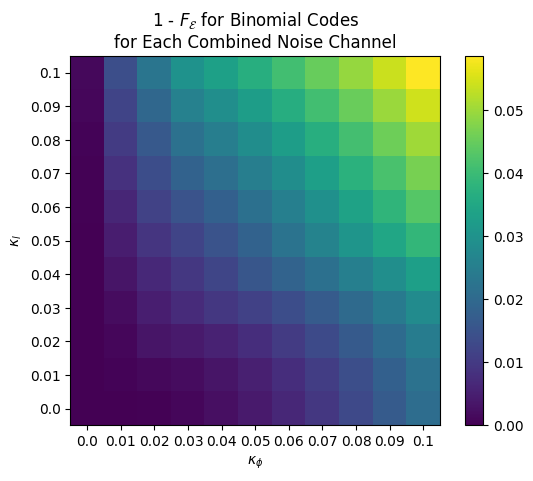

In [4]:
best_binomial_fidelities_per_region = np.max(binomial_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_binomial_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Binomial Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Binomial Code Parameters for Each Region

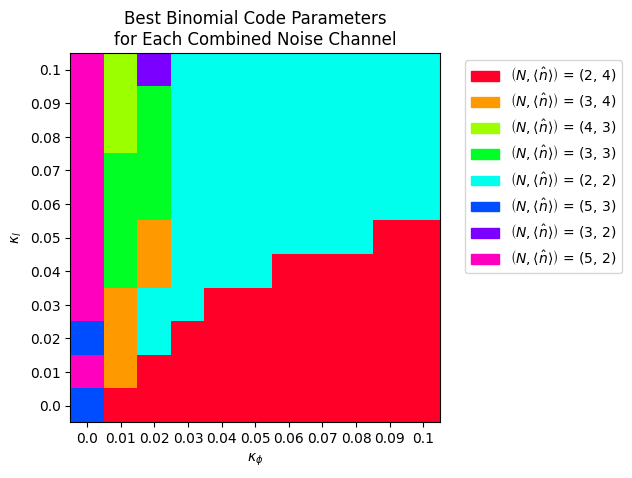

In [5]:
best_parameters = [[None for _ in dephasing_noise_values] for _ in loss_noise_values]
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		fidelities_in_region = binomial_fidelities[i,j]
		maximizing_indices = np.unravel_index(fidelities_in_region.argmax(), fidelities_in_region.shape)
		best_parameters[i][j] = (rotation_symmetries[maximizing_indices[0]], average_photon_numbers[maximizing_indices[1]])
unique_best_parameters = list(set([parameter for parameter_list in best_parameters for parameter in parameter_list]))
parameter_to_data = {value: index for index, value in enumerate(unique_best_parameters)}
image_data = np.array([[parameter_to_data[parameter] for parameter in sublist] for sublist in best_parameters])

plt.figure()
imshow = plt.imshow(image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Parameters\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(value)) for value in range(len(unique_best_parameters))]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$\\left(N, \\langle\\hat n\\rangle\\right)$ = {unique_best_parameters[i]}") for i in range(len(unique_best_parameters))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

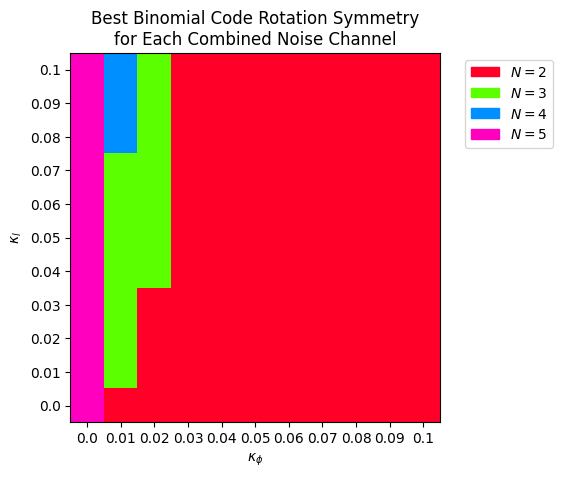

In [6]:
stripped_image_data = [[rotation_symmetry for rotation_symmetry, _ in sublist] for sublist in best_parameters]
unique_good_rotation_symmetries = list(set([rotation_symmetry for sublist in stripped_image_data for rotation_symmetry in sublist]))

plt.figure()
imshow = plt.imshow(stripped_image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Rotation Symmetry\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(rotation_symmetry)) for rotation_symmetry in unique_good_rotation_symmetries]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$N = {unique_good_rotation_symmetries[i]}$") for i in range(len(unique_good_rotation_symmetries))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

### Generate Fidelities for Two-Expanded Haar Random Codes

In [7]:
%%time

async_processes = []
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				for m in range(number_of_random_code_trials):
					dimension = (average_photon_number + 2) * rotation_symmetry
					combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
					random_code = code.make_two_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
					async_processes.append(pool.apply_async(code_simulator.get_fidelity_of, (random_code, combined_noise, True)))
[process.get() for process in async_processes];

CPU times: user 26min 25s, sys: 1min 19s, total: 27min 45s
Wall time: 2h 8min 12s


### Get the Best Stored Random Code Fidelities

In [8]:
%%time

def get_best_random_fidelity(loss_noise_value, dephasing_noise_value, rotation_symmetry, average_photon_number):
	dimension = (average_photon_number + 2) * rotation_symmetry
	combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
	code_name = f"two-expanded-haar-random-{rotation_symmetry},{average_photon_number},{dimension}"
	return code_simulator.get_known_fidelity_for(code_name, True, combined_noise, True)

random_fidelity_processes = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers))).tolist()
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				random_fidelity_processes[i][j][k][l] = pool.apply_async(get_best_random_fidelity, (loss_noise_value, dephasing_noise_value, rotation_symmetry, average_photon_number))
random_fidelities = np.empty((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers)))
for i in range(len(loss_noise_values)):
	for j in range(len(dephasing_noise_values)):
		for k in range(len(rotation_symmetries)):
			for l in range(len(average_photon_numbers)):
				random_fidelities[i,j,k,l] = random_fidelity_processes[i][j][k][l].get()

CPU times: user 2.35 s, sys: 185 ms, total: 2.53 s
Wall time: 4.83 s


### Random Code Optimal Fidelities in Each Region

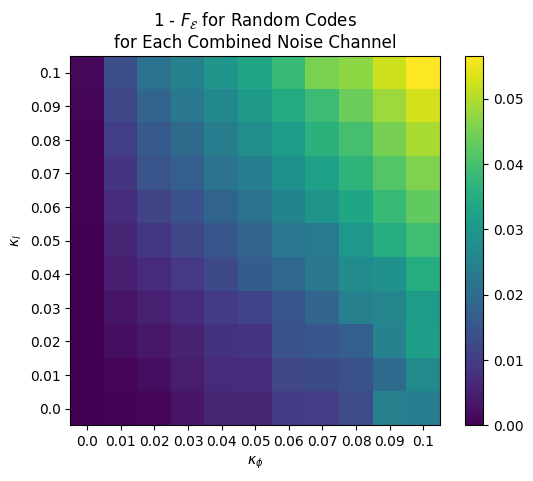

In [9]:
best_random_fidelities_per_region = np.max(random_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_random_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Random Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Code in Each Region

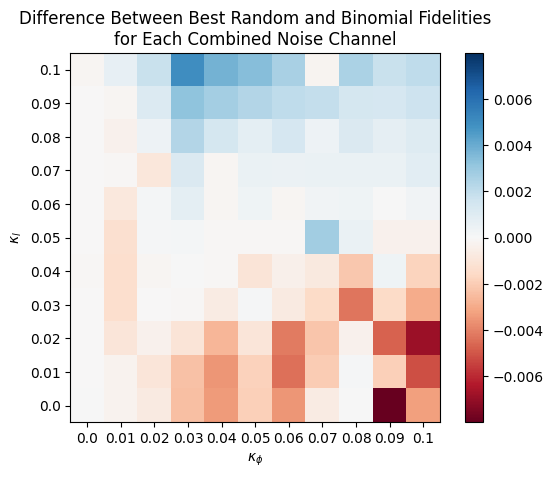

In [10]:
fidelity_difference = best_random_fidelities_per_region - best_binomial_fidelities_per_region

cmap = plt.get_cmap("RdBu")
most_extreme_fidelity_difference = max(np.max(fidelity_difference), np.max(-fidelity_difference))
normalizer = matplotlib.colors.Normalize(-most_extreme_fidelity_difference, most_extreme_fidelity_difference)

plt.figure()
plt.imshow(fidelity_difference, origin="lower", cmap=cmap, norm=normalizer)
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Difference Between Best Random and Binomial Fidelities\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())
plt.show()